In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
from functools import reduce
from operator import mul
from math import factorial
import einops
from koopman.simulation.simulator import simulate, simulate_batch
from koopman.simulation.systems import DynamicalSystem, Pendulum
from sklearn.preprocessing import PolynomialFeatures
from spatialmath.base import angle_wrap
from scipy.ndimage import gaussian_filter1d

In [8]:
xs = np.random.randn(100, 6)
C = np.array([
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
])

ys = einops.einsum(xs, C, 'n z, x z->n x')
assert np.allclose(ys, xs[:, :2])

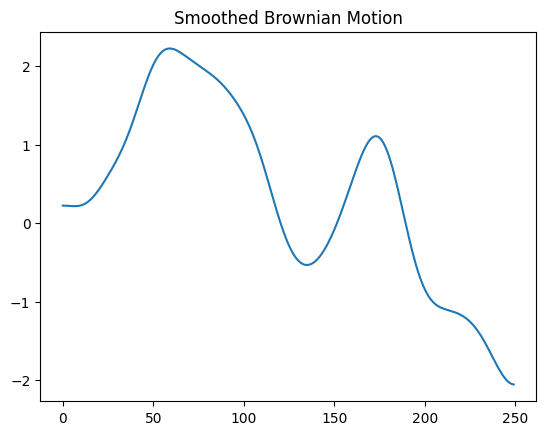

In [10]:
def reconstruct_from_pendulum_observables(observable, C):
    if len(observable.shape) == 1:
        observable = observable.reshape((1, observable.shape[0]))
    
    xs = einops.einsum(observable, C, 'n z, x z->n x')
    return xs.squeeze()

def compute_pendulum_observables(x):    
    if len(x.shape) == 1:
        x = x.reshape((1, 1, x.shape[0]))
    elif len(x.shape) == 2:
        x = x.reshape((1, x.shape[0], x.shape[1]))
        
    thetas = np.expand_dims(x[:, :, 0], axis=-1)
    omegas = np.expand_dims(x[:, :, 1], axis=-1)
    sin_theta = np.sin(thetas)
    cos_theta = np.cos(thetas)
        
    observables = np.concatenate([
        thetas,
        omegas,
        np.ones_like(thetas),
        sin_theta,
        cos_theta,
        sin_theta * omegas,
        cos_theta * omegas
    ], axis=-1)
    
    nx = x.shape[-1]
    nz = observables.shape[-1]
    
    C = np.block([
        [np.eye(nx), np.zeros((nx, nz - nx))],
    ])
    
    return observables.squeeze(), C

def generate_random_smooth_controls(N, T):
    dt = 0.1
    w = np.random.randn(N, T, 1) * np.sqrt(dt)
    b = np.cumsum(w, axis=1)
    b_smooth = gaussian_filter1d(b, sigma=10, axis=1)
    
    return b_smooth

u = generate_random_smooth_controls(32, 250)
u_sample = u[0, :, 0]
plt.plot(u_sample)
plt.title("Smoothed Brownian Motion")
plt.show()

In [12]:
# Test DMD method on linear system with known matrix
K = np.random.rand(3,3)
K = K.T @ K

N = 10
X = np.empty((N, 2, 3))
xs = np.random.rand(N, 3)
ys = xs @ K.T

pairs = np.stack([xs, ys], axis=0)
pairs = einops.rearrange(pairs, 'p n x -> n p x')

A, B = pairs[:, 0, :].T, pairs[:, 1, :].T

K_est = B @ np.linalg.pinv(A)
print("K estimated:\n", K_est)
print("K true:\n", K)

K estimated:
 [[0.71398536 0.636392   0.41054506]
 [0.636392   0.88463244 0.28257338]
 [0.41054506 0.28257338 0.58447199]]
K true:
 [[0.71398536 0.636392   0.41054506]
 [0.636392   0.88463244 0.28257338]
 [0.41054506 0.28257338 0.58447199]]


Simulation progress: 100%|██████████| 250/250 [00:00<00:00, 19125.87it/s]


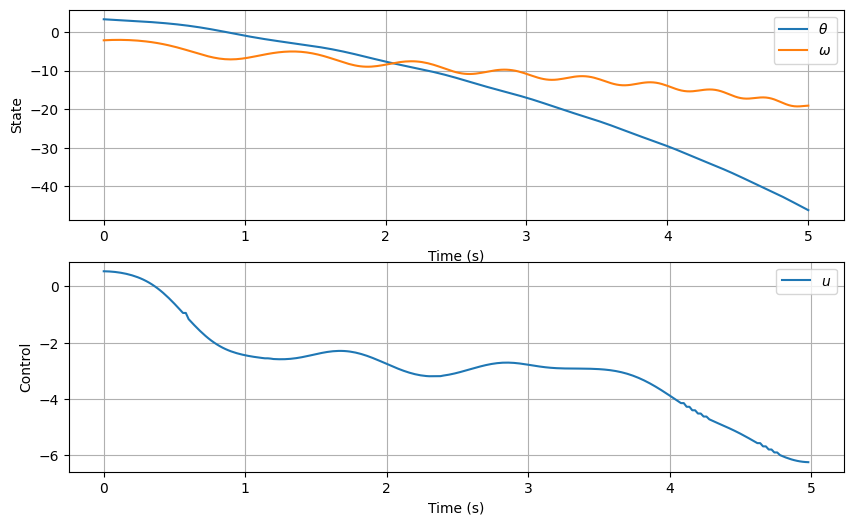

In [13]:
# Run a simulation with a pendulum
pendulum = Pendulum(Pendulum.Params(m=1, l=1, g=9.81))

N = 500
theta0 = np.random.uniform(0, 2*np.pi, (N, 1))
omega0 = np.random.uniform(-5.0, 5.0, (N, 1))
x0 = np.hstack((theta0, omega0))
tf = 5.0
dt = 0.02

smooth_controls = generate_random_smooth_controls(N, int(tf/dt))

def u(t, xs):
    return smooth_controls[:, int(t/dt), :]

ts, xhist, uhist = simulate_batch(
    sys=pendulum,
    tf=5.0,
    dt=0.02,
    u=u,
    x0=x0
)

# Visualize a random trajectory
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(ts, xhist[0, :, 0], label=r'$\theta$')
ax[0].plot(ts, xhist[0, :, 1], label=r'$\omega$')
ax[0].legend()
ax[0].grid(True)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('State')

ax[1].plot(ts[:-1], uhist[0, :, 0], label=r'$u$')
ax[1].legend()
ax[1].grid(True)
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Control')
plt.show()

In [15]:
phis_hist, phis_C = compute_pendulum_observables(xhist)
print("Shape of observables:", phis_hist.shape)

n_observables = phis_hist.shape[-1]
n_controls = uhist.shape[-1]

phis_curr = phis_hist[:, :-1, :]
us_curr = uhist[:, :, :]
phis_curr_and_us_curr = np.concatenate([phis_curr, us_curr], axis=-1)
phis_curr_and_us_curr = einops.rearrange(phis_curr_and_us_curr, 'n t o -> (n t) o').T

phis_next = phis_hist[:, 1:, :]
phis_next = einops.rearrange(phis_next, 'n t o -> (n t) o').T

A_lstsq = phis_curr_and_us_curr
B_lstsq = phis_next

KB = B_lstsq @ np.linalg.pinv(A_lstsq)
K = KB[:, :n_observables]
B = KB[:, n_observables:]

print("Condition # of K:", np.linalg.cond(K))
print("# of observables:", phis_hist.shape[-1])
print("K shape:", K.shape)
print("B shape:", B.shape)

Shape of observables: (500, 251, 7)
Condition # of K: 3.2016009183098086
# of observables: 7
K shape: (7, 7)
B shape: (7, 1)


In [19]:
# Take the simulated systems and roll it out with the learned Koopman operator
x0 = np.array([
    np.random.uniform(0, 2*np.pi),
    np.random.uniform(-10.0, 10.0)
    # np.pi-0.3,
    # 10.0
])

ts, xhist, uhist = simulate(
    sys=pendulum,
    tf=5.0,
    dt=0.02,
    u=lambda t, xs: np.array([2 * np.sin(t)]),
    x0=x0
)

xhist_pred = np.empty_like(xhist)
xhist_pred[0] = x0

for i in range(len(ts) - 1):
    x_curr = xhist[i]
    u_curr = uhist[i]
    
    phi_curr, C = compute_pendulum_observables(x_curr.reshape(1, -1))
    x_next = reconstruct_from_pendulum_observables(K @ phi_curr + B @ u_curr, C=C)
    xhist_pred[i+1] = x_next

max_pred_error = np.amax(np.linalg.norm(xhist_pred - xhist, axis=0))
print(f"Max state prediction error: {max_pred_error:.4f}")

Simulation progress: 100%|██████████| 250/250 [00:00<00:00, 17661.71it/s]

Max state prediction error: 0.0053


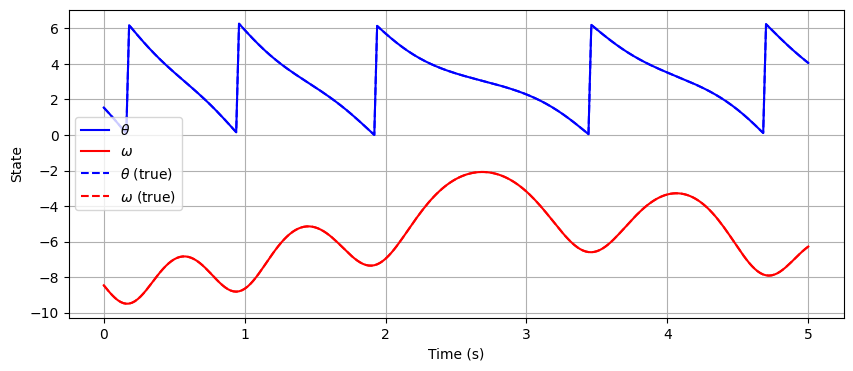

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(ts, angle_wrap(xhist_pred[:, 0], "0:2pi"), label=r'$\theta$', c='blue')
ax.plot(ts, xhist_pred[:, 1], label=r'$\omega$', c='red')

ax.plot(ts, angle_wrap(xhist[:, 0], "0:2pi"), '--', label=r'$\theta$ (true)', c='blue')
ax.plot(ts, xhist[:, 1], '--', label=r'$\omega$ (true)', c='red')

ax.legend()
ax.grid(True)
ax.set_xlabel('Time (s)')
ax.set_ylabel('State')
plt.show()